# library required

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob


In [129]:
import pandas as pd
import datetime
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS


import nltk
from nltk.stem.porter import *
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niloofar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Explatory Analysis

In [3]:
df=pd.read_csv("/Users/niloofar/Downloads/Hotel_Reviews.csv")

# total number of hotels:

len(set(df.Hotel_Name))
df.Hotel_Name.value_counts()

#change the format of time to datetime

df['Review_Date']=pd.to_datetime(df['Review_Date'], format='%m/%d/%Y')

In [4]:
#Selecting one sample hotel with highest number of review
df1=df[df.Hotel_Name=="Britannia International Hotel Canary Wharf"]

df1.index = range(df1.shape[0])

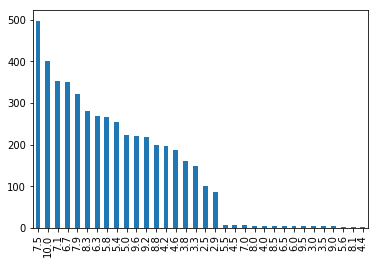

In [5]:
df1['Reviewer_Score'].value_counts().plot(kind='bar')

# Data pre-processing for textual variables

In [6]:
import pandas as pd
data_text = pd.DataFrame(df1['Positive_Review'])
data_text['Neg'] = df1['Negative_Review']
data_text['index'] = data_text.index
data_text.columns=['pos','neg','index']
data_text['pos']=["  " if x == 'No Positive' else x for x in data_text['pos']]
data_text['neg']=["  " if x == 'No Negative' else x for x in data_text['neg']]
# data_text['review']=data_text['pos']+data_text['neg']
# df=data_text['review']

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


In [8]:
docp=list(sent_to_words(data_text['pos']))
docn=list(sent_to_words(data_text['neg']))


In [17]:
Time_Table=df1[['Review_Date','Reviewer_Score']]

In [19]:
Time_Table.head()

,Review_Date,Reviewer_Score
0,2017-08-03,7.9
1,2017-08-03,8.3
2,2017-08-02,6.3
3,2017-08-02,5.4
4,2017-08-02,6.3


In [23]:
pre_docn=list(data_text['neg'])
pre_docp=list(data_text['pos'])

# Functions

In [21]:
# stop_list = ["Nothing","ok","good","great","excellent","very","london","nice","lovely","okay","like","wharf","canary","room","amaze",   
#              'Indian','Italian','hotel','room','nothing','great','excellent','good','ideal','one','people','pleasant','wa']
stop_words=['hotel','room','nothing','would','could','want','go','recommend','everything','be','was','good','ok','great','poor']            

In [37]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import English, STOP_WORDS
# from en_core_web_lg import *
# import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import pickle

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import ast

In [38]:
def process(input_data, no_list,time_table,start, limit, step,file_name,verbose):
    
    #'''data pre processing using spacy '''
    nlp = English()
    lp= spacy.load("en")
    nlp.Defaults.stop_words.update(stop_words)

    for word in STOP_WORDS:
        lexeme = nlp.vocab[word]
        lexeme.is_stop = True

    flatten = lambda l: [item for sublist in l for item in sublist]

    def spacy_root(text):
        nlp = spacy.load("en_core_web_sm")
        doc=[]
        l=[]
        for word in text:
            ss=nlp(word)
            for chunk in ss.noun_chunks:
                l.append(chunk.root.text)
        doc.append(l)
        return(doc)


    def lemmatizer(doc):
        # This takes in a doc of tokens from the NER and lemmatizes them. 
        # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
        doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
        doc = u' '.join(doc)
        return nlp.make_doc(doc)

    def remove_stopwords(doc):
        spacy_nlp = spacy.load('en_core_web_sm')
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

        for i in no_list:  
            STOP_WORDS.add(i)

        for word in STOP_WORDS:
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True

        tokens = [token.text for token in doc if not token.is_stop and token.is_punct != True and  len(token) >=3]
        tokens=[i.lower() for i in tokens]
        return tokens
    nlp.add_pipe(lemmatizer,name='lemmatizer')
    nlp.add_pipe(remove_stopwords, name="stopwords", last=True)
    nlp.add_pipe(spacy_root,name='root')

    def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

        coherence_values = []
        model_list = []
        for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
            model =gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())

        return model_list, coherence_values
    
    
     #build a topic model
    
    def format_topics_sentences(ldamodel, corpus, texts):
    
        sent_topics_df = pd.DataFrame()

        # Get main topic in each document
        for i, row_list in enumerate(ldamodel[corpus]):
            row = row_list[0] if ldamodel.per_word_topics else row_list            
            # print(row)
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:  # => dominant topic
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        return(sent_topics_df)

    if verbose==True:
            
    
        doc_list = []
        for doc in tqdm(input_data):
            pr = nlp(doc)
            doc_list.append(pr)
            
        dd=[flatten(i) for i in doc_list]
        
        with open(file_name, 'wb') as f:
            pickle.dump(dd, f)
        
        
    else:    
        
        with open(file_name, 'rb') as f:
            dd = pickle.load(f)

       
    
        
    words = corpora.Dictionary(dd)
    corpus = [words.doc2bow(doc) for doc in dd]
    

    model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=dd, start=start, limit=limit, step=step)
    opt=coherence_values.index(max(coherence_values))
    optimal_model=model_list[opt]

    df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=input_data)

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    df_dominant_topic=df_dominant_topic.merge(time_table, left_index=True, right_index=True)

    return(df_dominant_topic)





In [39]:

positive_topic=process(input_data=pre_docp, no_list=stop_words,time_table=Time_Table,start=3, limit=20, step=1,file_name="doc_pos",verbose=True)


In [178]:
positive_topic=process(input_data=pre_docp, no_list=stop_words,time_table=Time_Table,start=2, limit=10, step=1,file_name="doc_pos",verbose=False)



In [49]:
with open("/Users/niloofar/Documents/insight/data/cleaned/hotel1/positive", 'wb') as f:
            pickle.dump(positive_topic, f)

In [50]:
negative_topic=process(input_data=pre_docn, no_list=stop_words,time_table=Time_Table,start=3, limit=20, step=1,file_name="doc_neg",verbose=True)

In [53]:
with open("/Users/niloofar/Documents/insight/data/cleaned/hotel1/negative", 'wb') as f:
            pickle.dump(negative_topic, f)

In [215]:
topic_pos=pd.DataFrame({"Dominant_Topic": [0,1,2,3,4,5,6,7,8],
                    "Topic_Name":["Decoration","facility","location",
                                  "price","amenities","parking","general","staff_receptionist","Room_size"]})
                 



In [106]:
topic_neg=pd.DataFrame({"Dominant_Topic": [0,1,2,3,4,5,6,7],
                    "Topic_Name":["general","service_food","air_conditioning",
                                  "staff_receptionist","Decoration","bed/bath/shower","wifi","parking"]})
                 


In [217]:
def table_modify (table,topic_table):
    table=table.merge(topic_table, on=['Dominant_Topic'])
    table.loc[table.Topic_Perc_Contrib<0.3 ,'Topic_Name']='None'
    return(table[['Document_No','Review_Date','Reviewer_Score','Topic_Name']])

In [219]:
pos_topic_final=table_modify(positive_topic,topic_pos)
neg_topic_final=table_modify(negative_topic,topic_neg)

In [221]:
neg_topic_final.head()

,Document_No,Review_Date,Reviewer_Score,Topic_Name
0,0,2017-08-03,7.9,None
1,3,2017-08-02,5.4,bed/bath/shower
2,7,2017-08-02,5.4,bed/bath/shower
3,9,2017-08-02,7.5,bed/bath/shower
4,10,2017-08-02,8.8,bed/bath/shower


In [228]:
def table_process(table,input_data):
    
    
    def sentiment_analyzer_scores(sentence):
        analyser = SentimentIntensityAnalyzer()
        score = analyser.polarity_scores(sentence)
        return("{}".format(str(score)))
   
    aa=[sentiment_analyzer_scores(i) for i in input_data]
    sent_score=[ast.literal_eval(i) for i in aa]
    SC=pd.DataFrame(sent_score)
    SC['Document_No']=SC.index
    SC=SC[['compound','Document_No']]
    table2=table.merge(SC, on=['Document_No'])
    table2.loc[table2.Topic_Name=="None" ,'compound']=0
    return(table2)
    
#     return(table2.pivot(index='Document_No',columns='Topic_Name',values='neg'))
    

In [229]:
pos_sentiment=table_process(pos_topic_final,pre_docp)
neg_sentiment=table_process(neg_topic_final,pre_docn)

In [238]:
Tp=pos_sentiment[['Document_No','Topic_Name','compound']]
Tn=neg_sentiment[['Document_No','Topic_Name','compound']]

In [347]:
Tp1=Tp.pivot(index='Document_No',columns='Topic_Name',values='compound')
Tn1=Tn.pivot(index='Document_No',columns='Topic_Name',values='compound')

In [348]:
Tp1=Tp1.drop(['None'],axis=1)
Tn1=Tn1.drop(['None'],axis=1)

In [349]:
Tp1.shape[0]

4789

In [350]:
common_columns=list(set(Tp1.columns).intersection(Tn1.columns))
common_columns.append('Document_No')
# common_columns.remove('None')

In [351]:
Tp1=Tn1.merge(Tp1,on=common_columns)

In [352]:
# Tp1=Tp1.drop(['None'],axis=1)
Tp1=Tp1.fillna(0)
Tp1=Tp1.merge(neg_topic_final[['Document_No','Review_Date','Reviewer_Score']],on=['Document_No'])
# Tp1


In [353]:
zero_col=['general','Decoration','parking','staff_receptionist']
Tp1=Tp1.drop(zero_col,axis=1)
Tp1['sum']=Tp1['air_conditioning']+Tp1['bed/bath/shower']+Tp1['service_food']+Tp1['wifi']+Tp1['Room_size']+Tp1['amenities']+Tp1['facility']+Tp1['location']+Tp1['price']
Tp1=Tp1[Tp1['sum']!=0]

In [354]:
# xx=Tp1[['Decoration','Review_Date']]

Tp1.head()

,Document_No,air_conditioning,bed/bath/shower,service_food,wifi,Room_size,amenities,facility,location,price,Review_Date,Reviewer_Score,sum
0,0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.5719,2017-08-03,7.9,0.5719
3,3,0.0,-0.9578,0.0,0.0000,0.0,0.0,0.0,0.0,0.4466,2017-08-02,5.4,-0.5112
4,4,0.0,0.0000,0.0,0.4939,0.0,0.0,0.0,0.0,0.8843,2017-08-02,6.3,1.3782
6,7,0.0,-0.2006,0.0,0.0000,0.0,0.0,0.0,0.0,0.7269,2017-08-02,5.4,0.5263
7,9,0.0,0.2263,0.0,0.0000,0.0,0.0,0.0,0.0,0.8860,2017-08-02,7.5,1.1123


In [311]:
from __future__ import print_function
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular


In [312]:
predic_fn_rf=lambda x: model.rf.predict_proba(x).astype('float')

In [235]:
negative_topic.loc[25,'Text']

' Staff Those of you with poker faces you should smile more you should ask a guest whether is in a need of help with luggage not just whether he she wants to pay in advance for breakfast or open an account with you or whether would prefer a more expensive room Also saying good morning and good evening to your guests once in a while is good manners Looking like a gentleman won t make you one after all it s not everything in life about money Wifi Rooms with windows at an extra charge of 20 pounds day Taxi companies you co operate with that instead of 5 mins they turn up in 35 It s not your fault entirely but most definitely not your guests '

In [155]:
positive_topic[['Dominant_Topic','Keywords']].drop_duplicates()

,Dominant_Topic,Keywords
0,3.0,"location, staff, value, breakfast, money, love..."
5,7.0,"service, book, time, business, fault, bite, co..."
6,8.0,"size, night, space, cost, minute, day, bath, f..."
11,2.0,"view, office, window, river, date, rooms, bedr..."
14,6.0,"wharf, food, place, lot, deal, plenty, meeting..."
26,1.0,"price, bed, position, arrival, house, ease, re..."
62,0.0,"facility, restaurant, bathroom, floor, cleanli..."
69,5.0,"bar, area, tube, station, park, distance, atmo..."
94,4.0,"reception, style, furniture, stuff, coffee, re..."


In [153]:
neg_topic_final.head()

,Document_No,Review_Date,Reviewer_Score,Topic_Name
0,0,2017-08-03,7.9,None
1,3,2017-08-02,5.4,bed/bath/shower
2,7,2017-08-02,5.4,bed/bath/shower
3,9,2017-08-02,7.5,bed/bath/shower
4,10,2017-08-02,8.8,bed/bath/shower


In [137]:
aa=[sentiment_analyzer_scores(i) for i in pre_docn]
aa
sent_score=[ast.literal_eval(i) for i in aa]
SC=pd.DataFrame(sent_score)

In [148]:
table1=neg_topic_final[['Document_No','Topic_Name']]
table2=table1.merge(SC, on=['Document_No'])


In [146]:
neg_topic.loc[4784]

Document_No                                                        2579
Dominant_Topic                                                        0
Topic_Perc_Contrib                                               0.2763
Keywords              wasn, rooms, train, fact, age, bag, face, heat...
Text                   Room was very noisy from clanking of steam pipes
Review_Date                                         2017-03-24 00:00:00
Reviewer_Score                                                      6.7
Topic_Name                                                         None
Name: 4784, dtype: object